In [1]:
# -*- coding: utf-8 -*-
from hyperparams import Hyperparams as hp
import os
import codecs
from jamo import h2j, j2hcj
from tqdm import tqdm
import tensorflow as tf
import numpy as np
import librosa
import matplotlib.pyplot as plt

In [2]:
trascript = hp.transcript_pos
lines = codecs.open(trascript, 'r', 'utf-8').readlines()

if not (os.path.isdir(hp.mels_dir)):
    os.mkdir(hp.mels_dir)
    print('{%s} does not exist, created {%s}'.format(hp.mels_dir, hp.mels_dir))
    
if not (os.path.isdir(hp.mags_dir)):
    os.mkdir(hp.mags_dir)
    print('{%s} does not exist, created {%s}'.format(hp.mags_dir, hp.mags_dir))

In [3]:
def load_vocab():
    char2idx = {char: idx for idx, char in enumerate(hp.vocab)}
    idx2char = {idx: char for idx, char in enumerate(hp.vocab)}
    return char2idx, idx2char

In [62]:
fnames, texts, secs, text_lengths = [], [], [], []
char2idx, idx2char = load_vocab();

for line in tqdm(lines):
    line = j2hcj(line)
    fname, _, text, sec = line.strip().split('|')
    encodedText = [char2idx[char] for char in text]
    encodedText = np.array(encodedText, np.int32)#.tostring()
    fnames.append(fname); texts.append(encodedText)
    secs.append(float(sec)); text_lengths.append(len(encodedText))
    
fnames = np.asarray(fnames)
texts = np.asarray(texts)
secs = np.asarray(secs)

100%|█████████████████████████████████████████████████████████████████████████| 12853/12853 [00:01<00:00, 10606.90it/s]


In [5]:
maxLen, minLen = max(text_lengths), min(text_lengths)

In [6]:
def spectrogram(wav, nsc, nov, fs):
    
    
    S = librosa.feature.melspectrogram(y=wav, sr=fs, n_fft=nsc, hop_length=nov, power=2.0)
    dbS = 20 * np.log10(np.maximum(S, hp.eps))
    
    
    return dbS

def mel_spectrogram(wav, nsc, nov, fs):
    
    
    S = librosa.feature.melspectrogram(y=wav, sr=fs, n_fft=nsc, hop_length=nov, power=2.0, n_mels = hp.n_mels)
    dbS = 20 * np.log10(np.maximum(S, hp.eps))
    
    
    return dbS

In [7]:
for i in tqdm(range(0, len(fnames))):
    fname = fnames[i]
    text = texts[i]
    
    npy_name = fname.split('/')[1].replace('wav', 'npy')
    mel_path = os.path.join(hp.mels_dir, npy_name)
    mag_path = os.path.join(hp.mags_dir, npy_name)
    
    if os.path.isfile(mel_path) and os.path.isfile(mag_path):
        
        mag = np.load(mag_path)
        mel = np.load(mel_path) 
        
    else :
    
        fpath = os.path.join(hp.data_dir, fname)
        wav, fs = librosa.core.load(fpath, mono=True)
        nsc = np.int(fs * hp.nsc_sec)
        nov = np.int(fs * hp.nov_sec)
        mag = spectrogram(wav, nsc, nov, fs)
        mel = mel_spectrogram(wav, nsc, nov, fs)
        
        mag = mag / hp.max_db
        mel = mel / hp.max_db
        
        np.save(mag_path, mag)
        np.save(mel_path, mel)
    
#     plt.figure(figsize=(10, 4))
#     plt.subplot(1, 2, 1)
#     plt.imshow(mag, origin='lower')
#     plt.colorbar()
#     plt.subplot(1, 2, 2)
#     plt.imshow(mel, origin='lower')
#     plt.colorbar()
#     plt.show()

100%|██████████████████████████████████████████████████████████████████████████| 12853/12853 [00:08<00:00, 1502.99it/s]


In [8]:
with tf.variable_scope("embedding", reuse=None):
    lookup_table = tf.get_variable('lookup_table', 
                                   dtype=tf.float32, 
                                   shape=[len(hp.vocab), hp.embed_size],
                                   initializer=tf.truncated_normal_initializer(mean=0.0, stddev=0.01))

In [38]:
sess = tf.InteractiveSession()
sess.run(tf.initialize_all_variables())

In [39]:
sess.run(lookup_table)

array([[ 8.3378311e-03,  8.5533847e-04, -6.1533330e-03, ...,
        -1.0636770e-02,  7.3864171e-03,  8.3643673e-03],
       [ 2.0382318e-03,  1.0880148e-02, -9.2137624e-03, ...,
         9.4911577e-03, -1.4998282e-04, -1.3414133e-02],
       [ 6.4691389e-03,  6.7120991e-03, -2.7256801e-03, ...,
         4.1782963e-03, -8.5113766e-03,  1.3228535e-03],
       ...,
       [-4.1192989e-03,  1.4447247e-03,  4.2224466e-03, ...,
        -9.5777512e-03, -2.9819116e-03, -4.6134200e-03],
       [-5.4957764e-03,  1.7588193e-02, -1.2342790e-02, ...,
         8.6616911e-03, -4.6100598e-03, -3.5583870e-03],
       [-8.7126279e-03, -9.9431314e-03, -1.2043902e-02, ...,
         6.3082545e-05, -1.5802145e-02, -1.4828495e-02]], dtype=float32)

In [68]:
embed_texts = []

for i in range(len(texts)):
    text = texts[i]
    embed_text = tf.nn.embedding_lookup(lookup_table, text)
    embed_texts.append(embed_text)

In [88]:
lookup_table.name

'embedding/lookup_table:0'

In [69]:
encodedText

array([ 8, 28,  4, 14, 21,  0,  8, 37,  8, 34,  4,  8, 38,  2,  0,  8, 37,
        2, 20,  2, 14, 40,  0, 18, 20,  4, 18, 20,  4, 14, 21,  8, 32, 52])

In [72]:
x = sess.run(embed_texts)

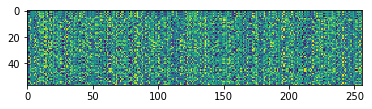

In [87]:
plt.imshow(x[20])